In [1]:
# coding: utf-8

import numpy as np
import torch
import os
import time

# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline  

from networks import *
from network import CoordRegressionNetwork
from torch.utils.data import DataLoader
from dataset_factory import DatasetFactory, ROOT_DIR
import multiprocessing
from tqdm import tqdm

# gpu setting
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.backends.cudnn.enabled = True
device = torch.device("cuda" if True else "cpu")
num_threads = multiprocessing.cpu_count()
print("GPU NUM: %d, Thread NUM: %d"%(torch.cuda.device_count(),num_threads))

%load_ext autoreload
%autoreload 2

GPU NUM: 1, Thread NUM: 20


In [2]:
# load pretrain model
# modelpath = "./models/resnet18_224_new_best.t7"
# modelname = "shufflenetv2"
modelname = "resnet18"
modelpath = "./models/%s_224_adam_best.t7"%(modelname)
inputsize = 224
net = CoordRegressionNetwork(n_locations=16, backbone=modelname).to(device)

train_dataset = DatasetFactory.get_train_dataset("resnet", inputsize)
train_dataloader = DataLoader(train_dataset, batch_size=256,
                        shuffle=True, num_workers = num_threads)

test_dataset = DatasetFactory.get_test_dataset("resnet", inputsize)
test_dataloader = DataLoader(test_dataset, batch_size=256,
                        shuffle=False, num_workers = num_threads)

  0%|          | 0/8 [00:00<?, ?it/s]

average forward seconds=0.012341 s| fps=81


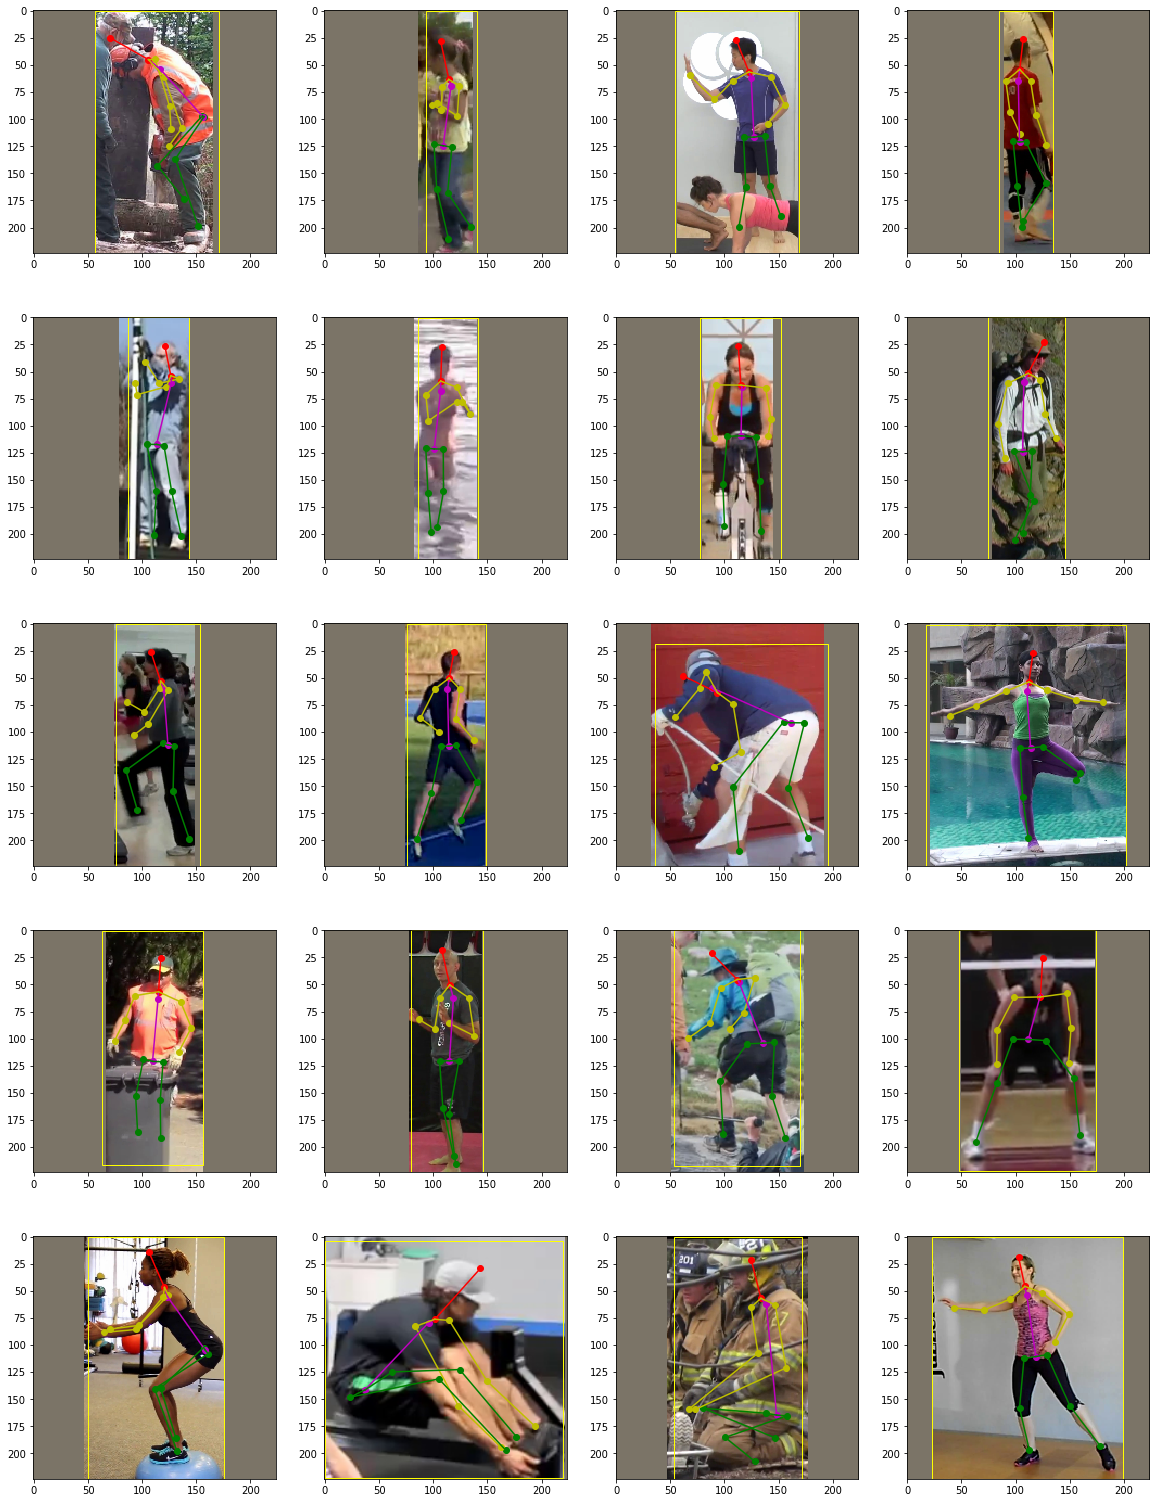

In [3]:
from dataloader import display_pose
plt.figure(figsize=(20,140))

with torch.no_grad():  
    net.load_state_dict(torch.load(modelpath))
    net = net.eval()

    for i_batch, sample_batched in enumerate(tqdm(test_dataloader)):

        images = sample_batched['image'].to(device)
        poses = sample_batched['pose'].to(device)
        
        t0 = time.clock()
        coords, heatmaps = net(images)
        t1 = time.clock()
        print('average forward seconds=%f s| fps=%d'%((t1-t0),int(1/((t1-t0)))))
        
        for ids in range(40,60):
            display_pose(images[ids][:3,:,:],coords[ids],ids)
        plt.show()
        break

In [ ]:
plt.imshow(heatmaps[0, 8].data.cpu().numpy())
plt.show()

In [ ]:
from torchsummary import summary
import torch
from networks import *
from networks.senet import se_resnet
from torchvision.models import resnet18
import os
device = torch.device("cuda" if True else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# model = se_resnet.senet18_ed().to(device)
model = resnet18_ed().to(device)
# model = resnet18().to(device)
# model = ShuffleNetV2.shufflenetv2_ed(width_mult=1.0).to(device)
# model = MobileNetV2.mobilenetv2_ed(width_mult=1.0).to(device)
# model = nn.Sequential(*(list(model.children())[:-3]))
# model = squeezenet1_1().to(device)
summary(model, input_size=(3, 224, 224))
# print(list(model.children())[:-1])

In [ ]:
from thop import profile
from torchsummary import summary
import torch
from networks import *
from torchvision.models import resnet18

import os
device = torch.device("cuda" if False else "cpu")

model = resnet.resnet18_ed().to(device)
# model = UNet().to(device)
# model = resnet18().to(device)
# model = ShuffleNetV2.shufflenetv2_ed(width_mult=1.0).to(device)
# model = MobileNetV2.mobilenetv2_ed(width_mult=1.0).to(device)
# model = squeezenet1_1().to(device)
flops, params = profile(model, input_size=(1, 3, 224,224))
print(params/(1024**2), flops/(1024**3))